In [1]:

# 🔧 Setup de base
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:

# 📦 Préparation des données MNIST
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [3]:
# ********** 1.1 CNN Custom **************

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64*56*56, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

model_cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)


In [4]:

# 🚂 Fonction d'entraînement générique
def train_model(model, name, epochs=3, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    start = time.time()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"{name} Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    total_time = time.time() - start
    print(f"{name} Training Time: {total_time:.2f}s")
    return losses, total_time


In [5]:

# 🎯 Fonction d'évaluation
def evaluate(model, name):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu()
            y_true.extend(labels)
            y_pred.extend(preds)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"{name} - Accuracy: {acc:.4f}, F1-score: {f1:.4f}")
    return acc, f1


In [6]:

# 🧪 Modèle ViT simple
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn((img_size // patch_size)**2 + 1, emb_size))

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size=768, heads=8, dropout=0.1, forward_expansion=4):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_size)
        self.attn = nn.MultiheadAttention(embed_dim=emb_size, num_heads=heads, batch_first=True)
        self.ln2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, forward_expansion * emb_size),
            nn.GELU(),
            nn.Linear(forward_expansion * emb_size, emb_size)
        )

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.ln1(x + attn_out)
        x = self.ln2(x + self.mlp(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, emb_size=768, num_classes=10, depth=6, heads=8):
        super().__init__()
        self.patch_embed = PatchEmbedding(3, patch_size, emb_size, img_size)
        self.encoder = nn.Sequential(*[TransformerEncoderBlock(emb_size, heads) for _ in range(depth)])
        self.cls_head = nn.Linear(emb_size, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.encoder(x)
        cls_token = x[:, 0]
        return self.cls_head(cls_token)


In [ ]:
import gc
from torchvision.models import VGG16_Weights, AlexNet_Weights

results = []

models_info = [
    ("CNN", CNN()),
    ("AlexNet", models.alexnet(weights=AlexNet_Weights.DEFAULT)),
]

for name, model in models_info:
    print(f"\n=== Training {name} ===")

    if name in ["VGG16", "AlexNet"]:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)

    try:
        model = model.to(device)
        losses, train_time = train_model(model, name, epochs=3)
        acc, f1 = evaluate(model, name)

    except RuntimeError as e:
        print(f"[ERROR] RuntimeError during training of {name}: {e}")
        acc, f1, train_time = 0.0, 0.0, 0.0

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "Training Time (s)": train_time
    })

    # Libération mémoire GPU même après erreur
    del model
    torch.cuda.empty_cache()
    gc.collect()



=== Training CNN ===
CNN Epoch 1, Loss: 0.4765
CNN Epoch 2, Loss: 0.3024
CNN Epoch 3, Loss: 0.2468
CNN Training Time: 353.93s
CNN - Accuracy: 0.9645, F1-score: 0.9645

=== Training VGG16 ===
[ERROR] RuntimeError during training of VGG16: CUDA out of memory. Tried to allocate 392.00 MiB. GPU 0 has a total capacity of 5.61 GiB of which 212.94 MiB is free. Including non-PyTorch memory, this process has 5.39 GiB memory in use. Of the allocated memory 5.24 GiB is allocated by PyTorch, and 35.76 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

=== Training AlexNet ===


In [ ]:

models_info = [
    ("VGG16", models.vgg16(weights=VGG16_Weights.DEFAULT)),
]

for name, model in models_info:
    print(f"\n=== Training {name} ===")

    if name in ["VGG16", "AlexNet"]:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)

    try:
        model = model.to(device)
        losses, train_time = train_model(model, name, epochs=3)
        acc, f1 = evaluate(model, name)

    except RuntimeError as e:
        print(f"[ERROR] RuntimeError during training of {name}: {e}")
        acc, f1, train_time = 0.0, 0.0, 0.0

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "Training Time (s)": train_time
    })

    # Libération mémoire GPU même après erreur
    del model
    torch.cuda.empty_cache()
    gc.collect()


In [ ]:


models_info = [
    ("ViT", ViT()),
]

for name, model in models_info:
    print(f"\n=== Training {name} ===")

    if name in ["VGG16", "AlexNet"]:
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 10)

    try:
        model = model.to(device)
        losses, train_time = train_model(model, name, epochs=3)
        acc, f1 = evaluate(model, name)

    except RuntimeError as e:
        print(f"[ERROR] RuntimeError during training of {name}: {e}")
        acc, f1, train_time = 0.0, 0.0, 0.0

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-Score": f1,
        "Training Time (s)": train_time
    })

    # Libération mémoire GPU même après erreur
    del model
    torch.cuda.empty_cache()
    gc.collect()


  Model  Accuracy  F1-Score  Training Time (s)
0   CNN     0.965  0.965006         352.009554


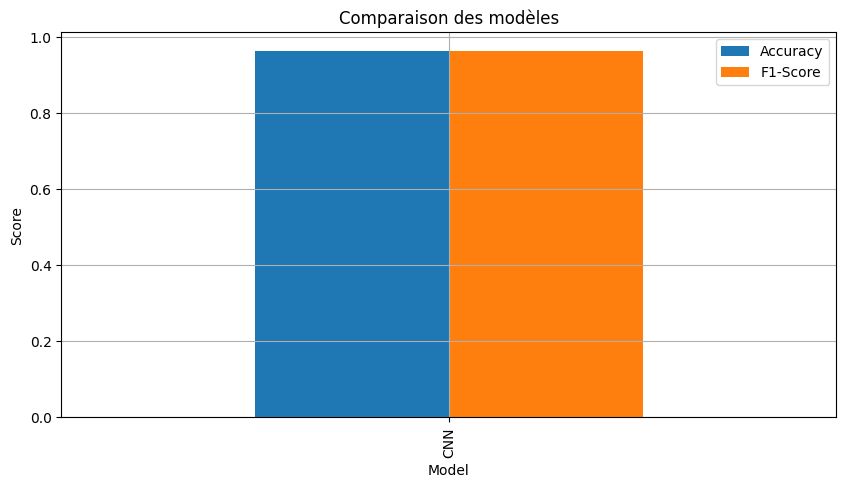

In [15]:

# 📊 Résultats finaux
df = pd.DataFrame(results)
print(df)

df.plot(x="Model", y=["Accuracy", "F1-Score"], kind="bar", title="Comparaison des modèles", figsize=(10, 5))
plt.ylabel("Score")
plt.grid(True)
plt.show()
